In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## 1. Document/Text Processing and Embedding Creation

Ingredients:
* PDF document `Space Mission Analysis and Design 3rd Edition (2005).pdf` .
* Embedding model  `google/bert_uncased_L-12_H-768_A-12`  .

Steps:
1. Import PDF document.
2. Process text for embedding (e.g. split into chunks of sentences).
3. Embed text chunks with embedding model.
4. Save embeddings to file for later use (embeddings will store on file ).

In [2]:
# Download PDF file
import os
import requests

# Get PDF document
SMAD = 'Data sets\Space Mission Analysis and Design 3rd Edition (2005).pdf'

# Download PDF if it doesn't already exist
if not os.path.exists(SMAD):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  url = "https://raw.githubusercontent.com/abdohisham12/RAG-model/refs/heads/main/Data%20sets/Space%20Mission%20Analysis%20and%20Design%203rd%20Edition%20(2005).pdf"


  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(SMAD, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {SMAD}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {SMAD} exists.")

File Data sets\Space Mission Analysis and Design 3rd Edition (2005).pdf exists.


In [3]:
import re

def preprocess_text(raw_text):
    # Remove headers like "7.1 Introduction and Overview"
    cleaned_text = re.sub(r"^\d+\.\d+.*?\n", "", raw_text, flags=re.MULTILINE)
    
    # Fix broken words and lines
    cleaned_text = cleaned_text.replace("\n", " ").replace("-", "")
    cleaned_text = re.sub(r"\s+", " ", cleaned_text).strip()
    
    # Remove page numbers or irrelevant metadata (like "Fig. 1-1")
    cleaned_text = re.sub(r"\bFig\.\s?\d+-\d+.*?\.", "", cleaned_text)
    cleaned_text = re.sub(r"\bPage\s?\d+.*?", "", cleaned_text)
    
    return cleaned_text

In [4]:
# Requires !pip install PyMuPDF, see: https://github.com/pymupdf/pymupdf
import fitz # (pymupdf, found this is better than pypdf for our use case, note: licence is AGPL-3.0, keep that in mind if you want to use any code commercially)
from tqdm.auto import tqdm # for progress bars, requires !pip install tqdm 

def text_formatter(text: str) -> str:
    """Performs minor formatting on text, including removing the first line."""
    # Split the text into lines
    lines = text.split("\n")
    
    # Remove the first line if it exists
    if len(lines) > 1:
        cleaned_text = " ".join(lines[1:])  # Join remaining lines into a single string
    else:
        cleaned_text = text  # If no \n is found, use the original text
    
    # Strip excess whitespace
    cleaned_text = cleaned_text.strip()
    
    # Return the formatted text
    return cleaned_text


# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures etc
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        text= preprocess_text(text)
        page_number =  page_number   - 17
        pages_and_texts.append({"page_number": page_number ,  # adjust page numbers since our PDF starts on page 10
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=SMAD)
pages_and_texts[:20]

0it [00:00, ?it/s]

[{'page_number': -17,
  'page_char_count': 537,
  'page_word_count': 79,
  'page_sentence_count_raw': 6,
  'page_token_count': 134.25,
  'text': 'Analysis and Design Third Edition Edited by Wiley J. Larson United States Air Force Academv and James R. Wertz Microcosm,Inc. Coordination by Douglas Kirkpatrick,United States Air Force Acaderny Donna Klungle, Microcosm, Inc. This book is published as part of the Space Tecbnology Series, a cooperative activity o{ the Unircd Shtes Department of Defense and National Aeronautics and Space Adminisuation. Space T Library Published Jointly by Microcosm Press EI Segundo, Califomia \\a7N Kluwer Academic Publishers Dordecht / Boston / London'},
 {'page_number': -16,
  'page_char_count': 1468,
  'page_word_count': 224,
  'page_sentence_count_raw': 20,
  'page_token_count': 367.0,
  'text': 'Library of Congress CataloginginPublication Data A C.I.P. Catalogue record for this book is available from the Library of Congress. ISBN 1881883108 (pb) (acidfree p

Now let's get a random sample of the pages.

In [5]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 731,
  'page_char_count': 3348,
  'page_word_count': 596,
  'page_sentence_count_raw': 36,
  'page_token_count': 837.0,
  'text': "Launch System Selection Process 737 six ignite at liftoff and stage at 57 sec. The other three ignite at altitude during the fust stage burn. The first and second stages are staged at 265 and,440 sec respectively. The third stage uses a spinstabilized Star 48 B rocket motor in the PAMD upper stage. Atlas/Centaur launch vehicles include the Atlas I, Atlas tr, Atlas IIA, and Atlas IIAS. The Atlas vehicle's core system uses liquid oxygen and hydrocarbons (RPl) in a stageandahalf form, with three engines ignited at liftoff. Two of these booster engines jettison at I'72 sec, and the third sustainer engine burns for another 1 1 I sec. The Atlas is inertially guided and controlled in pitch and yaw by gimballed engines. Vernier engines on Atlas I control roll in the first stage. For Atlas I[, IIA, and IIAS, a hydrazine roll control system attached 

In [6]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-17,537,79,6,134.25,Analysis and Design Third Edition Edited by Wi...
1,-16,1468,224,20,367.00,Library of Congress CataloginginPublication Da...
2,-15,1354,212,6,338.50,List of Authors Preface 6. Introducfion to Ast...
3,-14,1406,208,5,351.50,Table of Contents Orbit and Constellation Desi...
4,-13,1556,232,9,389.00,"533 534 543 550 570 575 587 590 600 611 6,t6 6..."


In [7]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1003.00,1003.00,1003.00,1003.00,1003.00
mean,484.00,2335.15,369.23,22.55,583.79
std,289.69,951.68,147.67,13.97,237.92
min,-17.00,0.00,1.00,1.00,0.00
25%,233.50,1694.50,277.50,14.00,423.62
50%,484.00,2436.00,383.00,21.00,609.00
75%,734.50,3034.00,473.50,28.00,758.50
max,985.00,4905.00,1013.00,120.00,1226.25


Okay, looks like our average token count per page is 583.

For this particular use case, it means we could embed an average whole page with the `"google/bert_uncased_L-12_H-768_A-12` model (this model has an input capacity 512 token ).

### Further text processing (splitting pages into sentences)

we will break the text into chunks of sentences.

`Ingest text -> split it into groups/chunks -> embed the groups/chunks -> use the embeddings`

 *we can*
1. Split into sentences with simple rules (e.g. split on ". " with `text = text.split(". ")`, like above).
2. Split into sentences with a natural language processing (NLP) library such as [spaCy](https://spacy.io/) or [nltk](https://www.nltk.org/).
 

In [8]:
! pip install spacy

In [9]:
from spacy.lang.en import English # see https://spacy.io/usage for install instructions

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/ 
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

# Access the sentences of the document
list(doc.sents)

[This is a sentence., This another sentence.]

We don't necessarily need to use spaCy, however, it's an open-source library designed to do NLP tasks like this at scale.

So let's run our small sentencizing pipeline on our pages of text.

In [10]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)
    
    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    
    # Count the sentences 
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1003 [00:00<?, ?it/s]

In [11]:
# Inspect an example
random.sample(pages_and_texts, k=1)

[{'page_number': 148,
  'page_char_count': 3076,
  'page_word_count': 546,
  'page_sentence_count_raw': 28,
  'page_token_count': 769.0,
  'text': "Introduction to Astrodynamics Altematively, we can write the total LV required for a twoburn transfer between circular orbits at radii r, andru: LVrornt = LVe + LVs (631) =.[i (632\\ (633) (634) (63s) 636) where fi = 63 I .348 I when A Z is in km/s and all of the semimajor axes are in km. As in step I above, d,_,= (rn + rs ) I 2. The above expression applies to any coplanar Hohmann transfer. In the case ofsmall transfers (that is, r, close to r;/, we can approxirnate this conveniently in two fonns: where LV =V,n V,u LV =0.5 (Lr / r)Vo,u Lr = rB rA f fA = fB Vnro =V1,a xVlg and To make the orbit change, we divide the AZinto two small bums are of approximately equal magnitude. The result in Eq. (633) is more unusual than it might seem at first. Assume that a satellite is in a circular orbit with velocity (r. In two burns we increase the veloc

Now let's turn out list of dictionaries into a DataFrame and get some stats.

In [12]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1003.00,1003.00,1003.00,1003.00,1003.00,1003.00
mean,484.00,2335.15,369.23,22.55,583.79,21.61
std,289.69,951.68,147.67,13.97,237.92,12.64
min,-17.00,0.00,1.00,1.00,0.00,0.00
25%,233.50,1694.50,277.50,14.00,423.62,13.00
50%,484.00,2436.00,383.00,21.00,609.00,21.00
75%,734.50,3034.00,473.50,28.00,758.50,28.00
max,985.00,4905.00,1013.00,120.00,1226.25,143.00


For our set of text, it looks like our raw sentence count (e.g. splitting on `". "`) is quite close to what spaCy came up with.

Now we've got our text split into sentences, how about we group those sentences into chunks?

In [13]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 20 

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list, 
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 37 sentences would be split into two lists of [[20], [17]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1003 [00:00<?, ?it/s]

In [14]:
# Sample an example from the group (note: many samples have only 1 chunk as they have <=10 sentences total)
random.sample(pages_and_texts, k=1)

[{'page_number': 574,
  'page_char_count': 1699,
  'page_word_count': 288,
  'page_sentence_count_raw': 15,
  'page_token_count': 424.75,
  'text': 'Comrnunications Architecture Fig. 1314. Multibeam coverage. To transmit simultaneously to A, B, and c, a multibeam antenna or a beamhopping antenna, with timedivision multiplexing, will support higher data rates with lower transmitter power compared to a single, lower gain, broadbeam antenna svstem. TABLE 1316\' Size and Mass of Typical Spacecraft Antennas. Antennas with shaoed or multiple beams include the mass of complex feed systems. Lower gain values are at edge of coverage. The mass of a satellite antenna, including feed, depends largely on its size and the materials used in its construction. These factors are irturn a function of the frequency and beamwidth or gain. Table l316 lists some examples of satellite antenna *"igttti, showing that the more complex shapedbeam antennas have relatively high mass because of their complex feed ne

In [15]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1003.00,1003.00,1003.00,1003.00,1003.00,1003.00,1003.00
mean,484.00,2335.15,369.23,22.55,583.79,21.61,1.58
std,289.69,951.68,147.67,13.97,237.92,12.64,0.67
min,-17.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,233.50,1694.50,277.50,14.00,423.62,13.00,1.00
50%,484.00,2436.00,383.00,21.00,609.00,21.00,2.00
75%,734.50,3034.00,473.50,28.00,758.50,28.00,2.00
max,985.00,4905.00,1013.00,120.00,1226.25,143.00,8.00


Note how the average number of chunks is around 1.5, this is expected since many of our pages only contain an average of 15 sentences.

### Splitting each chunk into its own item

We'd like to embed each chunk of sentences into its own numerical representation.

we will create a new list of dictionaries each containing a single chunk of sentences with relative information such as page number as well statistics about each chunk.

In [16]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]
        
        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo 
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters
        
        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/1003 [00:00<?, ?it/s]

1582

In [17]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'page_number': 700,
  'sentence_chunk': '17.3 Flemote Safe and Am Device Fig.177. Typical Solid Propellant Rocket Motor. ETA is the Explosive Transfer Assembly.have several attractive features. These include: (1) safetyit is impossible to create an explosive mixture of fuel and oxidizer; (2) throttlingwe can throttle the engine by modulating the oxidizer flow rate (useful for load alleviation during maximum dynarnic pressure and for trajectory shaping). We can idle the engine also (107o thrust) to ensure system operation prior to launch commit; (3) restartwe can shut it off and restart it; (4) storabilitythe fuel is storable, as are many oxidizers; (5) environmen tally cleanunlike solid rockets, hybrids can be made which produce no hydrochloric acid or aluminum oxide exhaust. Combustion Chamber Valve Iniector %t4, I I Relief Vent Generator Fill Drain Fig.178. Schematic Drawing of a Hybrid Rocket. The Califomia Rocket Society built hybrid rockers in the 1930s. The Califomia based Paci

Let's get some stats about our chunks.

In [18]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1582.00,1582.00,1582.00,1582.00
mean,477.34,1477.94,231.90,369.49
std,285.05,849.98,133.18,212.50
min,-17.00,1.00,1.00,0.25
25%,238.00,744.25,114.00,186.06
50%,474.50,1472.00,231.00,368.00
75%,723.00,2139.00,342.00,534.75
max,985.00,3727.00,625.00,931.75


Hmm looks like some of our chunks have quite a low token count.

How about we check for samples with less than 30 tokens (about the length of a sentence) and see if they are worth keeping?

In [19]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 17.0 | Text: 1 3 ) Table 1313 Table 1121 Tables I t t Y , t o r z Table 1 126 N/A
Chunk token count: 22.0 | Text: The analog and digital signal Analog to Digitat Conversion Power Supply and Conditioning
Chunk token count: 7.25 | Text: Command and Data Handling 405
Chunk token count: 6.0 | Text: 49.5 1 .52.53.< A 55.56.
Chunk token count: 20.75 | Text: Size of power storage in case of a short circuit . Location of fuses and their type


Looks like many of these are headers and footers of different pages.

They don't seem to offer too much information.

Let's filter our DataFrame/list of dictionaries to only include chunks with over 30 tokens in length.

In [20]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -17,
  'sentence_chunk': 'Analysis and Design Third Edition Edited by Wiley J. Larson United States Air Force Academv and James R. Wertz Microcosm,Inc. Coordination by Douglas Kirkpatrick,United States Air Force Acaderny Donna Klungle, Microcosm, Inc. This book is published as part of the Space Tecbnology Series, a cooperative activity o{ the Unircd Shtes Department of Defense and National Aeronautics and Space Adminisuation. Space T Library Published Jointly by Microcosm Press EI Segundo, Califomia \\a7N Kluwer Academic Publishers Dordecht / Boston / London',
  'chunk_char_count': 537,
  'chunk_word_count': 79,
  'chunk_token_count': 134.25},
 {'page_number': -16,
  'sentence_chunk': 'Library of Congress CataloginginPublication Data A C. I. P. Catalogue record for this book is available from the Library of Congress. ISBN 1881883108 (pb) (acidfree paper) ISBN 0792359011 (hb) (acidfree paper) Cover photo of Earthfront Space: View ofAfrica and the Indian Ocean taken in D

### Embedding our text chunks

While humans understand text, machines understand numbers best.

An [embedding](https://vickiboykis.com/what_are_embeddings/index.html) is a broad concept.

But one of my favourite and simple definitions is "a useful numerical representation".

The most powerful thing about modern embeddings is that they are *learned* representations.

Meaning rather than directly mapping words/tokens/characters to numbers directly (e.g. `{"a": 0, "b": 1, "c": 3...}`), the numerical representation of tokens is learned by going through large corpuses of text and figuring out how different tokens relate to each other.

Ideally, embeddings of text will mean that similar meaning texts have similar numerical representation.

> **Note:** Most modern NLP models deal with "tokens" which can be considered as multiple different sizes and combinations of words and characters rather than always whole words or single characters. For example, the string `"hello world!"` gets mapped to the token values `{15339: b'hello', 1917: b' world', 0: b'!'}` using [Byte pair encoding](https://en.wikipedia.org/wiki/Byte_pair_encoding) (or BPE via OpenAI's [`tiktoken`](https://github.com/openai/tiktoken) library). Google has a tokenization library called [SentencePiece](https://github.com/google/sentencepiece).

Our goal is to turn each of our chunks into a numerical representation (an embedding vector, where a vector is a sequence of numbers arranged in order).

Once our text samples are in embedding vectors, us humans will no longer be able to understand them.

However, we don't need to.

The embedding vectors are for our computers to understand.

We'll use the [`sentence-transformers`](https://www.sbert.net/docs/installation.html) library which contains many pre-trained embedding models.

Specifically, we'll get the `google/bert_uncased_L-12_H-768_A-12` model (you can see the model's intended use on the [Hugging Face model card](https://huggingface.co/google/bert_uncased_L-12_H-768_A-12)).

In [21]:
! pip install transformers

In [22]:
from transformers import BertTokenizer, BertModel
import torch

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("google/bert_uncased_L-12_H-768_A-12")
model = BertModel.from_pretrained("google/bert_uncased_L-12_H-768_A-12")

# Create a list of sentences to embed
sentences = [
    "The Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Encode sentences and compute embeddings
embeddings_dict = {}
for sentence in sentences:
    # Tokenize and convert to input tensors
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
    
    # Pass inputs through the model to get embeddings
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Use the last hidden state (average pooling)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    embeddings_dict[sentence] = embeddings

# Display embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")


C:\Users\abdoh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Sentence: The Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-4.45841402e-01  1.96945116e-01  3.36758614e-01 -3.94707136e-02
  4.94547427e-01 -2.44086176e-01  8.79626125e-02  1.57351539e-01
 -1.43819153e-02  5.25129676e-01  5.63219488e-01 -5.18579125e-01
  3.84036526e-02 -3.92102420e-01  3.16366225e-01 -9.66247737e-01
 -3.96435261e-02  7.41160035e-01  2.09225751e-02  7.78543651e-01
  5.15153110e-01 -4.00425971e-01  2.46467944e-02  3.93699557e-01
  7.02830330e-02 -1.97937086e-01 -8.76130257e-03 -2.76027799e-01
  2.82000303e-01  7.43711879e-03  1.15442850e-01  7.14140758e-02
 -5.69592118e-01 -1.35397136e-01 -4.64847796e-02  1.44765422e-01
 -2.22821623e-01  4.23875898e-01 -1.15877867e-01  1.91334039e-01
 -4.85559814e-02  2.09849715e-01 -3.77683528e-02 -2.32481807e-01
  4.76977527e-01  3.65975767e-01 -4.03843001e-02  3.37887704e-01
 -4.11987156e-01 -3.48338336e-01  1.07022837e-01 -2.25027248e-01
  3.59642148e-01  3.65638882e-01  6.37514964e-02  

Woah! That's a lot of numbers.

How about we do just once sentence?

In [23]:
single_sentence = "this is our test sentence for embedding"

# Tokenize the sentence and convert to input tensors
inputs = tokenizer(single_sentence, return_tensors="pt", padding=True, truncation=True)

# Pass the inputs through the model to get embeddings
with torch.no_grad():
    outputs = model(**inputs)

# Use the last hidden state (average pooling across all tokens)
embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Store the embedding in the dictionary
embeddings_dict[single_sentence] = embeddings

# Display the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("Embedding size:", embedding.shape)

Sentence: The Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-4.45841402e-01  1.96945116e-01  3.36758614e-01 -3.94707136e-02
  4.94547427e-01 -2.44086176e-01  8.79626125e-02  1.57351539e-01
 -1.43819153e-02  5.25129676e-01  5.63219488e-01 -5.18579125e-01
  3.84036526e-02 -3.92102420e-01  3.16366225e-01 -9.66247737e-01
 -3.96435261e-02  7.41160035e-01  2.09225751e-02  7.78543651e-01
  5.15153110e-01 -4.00425971e-01  2.46467944e-02  3.93699557e-01
  7.02830330e-02 -1.97937086e-01 -8.76130257e-03 -2.76027799e-01
  2.82000303e-01  7.43711879e-03  1.15442850e-01  7.14140758e-02
 -5.69592118e-01 -1.35397136e-01 -4.64847796e-02  1.44765422e-01
 -2.22821623e-01  4.23875898e-01 -1.15877867e-01  1.91334039e-01
 -4.85559814e-02  2.09849715e-01 -3.77683528e-02 -2.32481807e-01
  4.76977527e-01  3.65975767e-01 -4.03843001e-02  3.37887704e-01
 -4.11987156e-01 -3.48338336e-01  1.07022837e-01 -2.25027248e-01
  3.59642148e-01  3.65638882e-01  6.37514964e-02  

Nice! We've now got a way to numerically represent each of our chunks.

Our embedding has a shape of `(768,)` meaning it's a vector of 768 numbers which represent our text in high-dimensional space, too many for a human to comprehend but machines love high-dimensional space.

> **Note:** No matter the size of the text input to our `google/bert_uncased_L-12_H-768_A-12` model, it will be turned into an embedding size of `(768,)`. This value is fixed. So whether a sentence is 1 token long or 1000 tokens long, it will be truncated/padded with zeros to size 384 and then turned into an embedding vector of size `(768,)`. Of course, other embedding models may have different input/output shapes.

How about we add an embedding field to each of our chunk items?

Let's start by trying to create embeddings on the CPU, we'll time it with the `%%time` magic to see how long it takes.

In [24]:
! pip install torch

In [25]:
import torch
print(torch.cuda.is_available())  # Should return True if GPU is available
print(torch.cuda.device_count())  # Number of GPUs detected
print(torch.cuda.get_device_name(0))  # Name of the first GPU

True
1
NVIDIA GeForce RTX 4050 Laptop GPU


In [26]:
! nvidia-smi

Fri Dec 20 13:16:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8              2W /   84W |       0MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [27]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124


In [28]:
import torch
print(torch.__version__)  # Check PyTorch version
print(torch.cuda.is_available())  # Should return True if CUDA is enabled


2.5.1+cu124
True


In [29]:
!nvcc --version

'nvcc' is not recognized as an internal or external command,
operable program or batch file.


In [30]:
import torch
from tqdm import tqdm
import time

def chunk_text(text, tokenizer, max_length):
    """Splits text into chunks within the max token length of the model."""
    tokens = tokenizer.encode(text, truncation=False)
    chunks = [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]
    return [tokenizer.decode(chunk, skip_special_tokens=True) for chunk in chunks]

# Start the timer
start_time = time.time()

# Check if CUDA (GPU) is available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Process each chunk
for item in tqdm(pages_and_chunks_over_min_token_len):
    sentence_chunk = item["sentence_chunk"]
    
    # Split and process large chunks
    split_chunks = chunk_text(sentence_chunk, tokenizer, max_length=512)
    embeddings_list = []
    
    for chunk in split_chunks:
        inputs = tokenizer(chunk, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
        embeddings_list.append(embedding)
    
    # Combine embeddings if split
    item["embedding"] = sum(embeddings_list) / len(embeddings_list)

# End the timer
end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")


100%|██████████| 1530/1530 [00:35<00:00, 42.73it/s]

Execution time: 35.993083238601685 seconds


In [31]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [32]:
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import numpy as np

# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained("google/bert_uncased_L-12_H-768_A-12")
model = BertModel.from_pretrained("google/bert_uncased_L-12_H-768_A-12")

# Move the model to the appropriate device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Assuming text_chunks is your list of text segments
batch_size = 32
text_chunk_embeddings = []

# Function to process batches
def process_batch(batch_texts):
    # Tokenize batch with padding and truncation
    inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # Pass through the model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Average pooling on last hidden state
    embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    return embeddings

# Batch processing
for i in tqdm(range(0, len(text_chunks), batch_size)):
    batch_texts = text_chunks[i:i + batch_size]
    batch_embeddings = process_batch(batch_texts)
    text_chunk_embeddings.extend(batch_embeddings)

# Convert to numpy array for further processing
text_chunk_embeddings = np.array(text_chunk_embeddings)

# Check the result
print("Embeddings shape:", text_chunk_embeddings.shape)


100%|██████████| 48/48 [00:37<00:00,  1.28it/s]

Embeddings shape: (1530, 768)


### Save embeddings to file

Since creating embeddings can be a timely process (not so much for our case but it can be for more larger datasets), let's turn our `pages_and_chunks_over_min_token_len` list of dictionaries into a DataFrame and save it.

In [33]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

And we can make sure it imports nicely by loading it.

In [34]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-17,Analysis and Design Third Edition Edited by Wi...,537,79,134.25,[-1.61226615e-01 2.47742891e-01 3.35289627e-...
1,-16,Library of Congress CataloginginPublication Da...,1472,228,368.00,[-1.98725924e-01 1.66512668e-01 1.50661752e-...
2,-15,List of Authors Preface 6. Introducfion to Ast...,1353,211,338.25,[-3.60170245e-01 -2.68641971e-02 2.34605312e-...
3,-14,Table of Contents Orbit and Constellation Desi...,1402,204,350.50,[-2.13003412e-01 -9.46922507e-03 3.34786505e-...
4,-13,"533 534 543 550 570 575 587 590 600 611 6,t6 6...",1550,226,387.50,[-3.99737358e-01 6.92753047e-02 3.85398209e-...


## 2. RAG - Search and Answer

We discussed RAG briefly in the beginning but let's quickly recap.

RAG stands for Retrieval Augmented Generation.

Which is another way of saying "given a query, search for relevant resources and answer based on those resources".

Let's breakdown each step:
* **Retrieval** - Get relevant resources given a query. For example, if the query is "what is the best mission for water detection on Mars?" the ideal results will contain information about Mars mission design and landcover rather than information about how to reach the moon with lowest possible cost).
* **Augmentation** - LLMs are capable of generating text given a prompt. However, this generated text is designed to *look* right. And it often has some correct information, however, they are prone to hallucination (generating a result that *looks* like legit text but is factually wrong). In augmentation, we pass relevant information into the prompt and get an LLM to use that relevant information as the basis of its generation.
* **Generation** - This is where the LLM will generate a response that has been flavoured/augmented with the retrieved resources. In turn, this not only gives us a potentially more correct answer, it also gives us resources to investigate more (since we know which resources went into the prompt).

The whole idea of RAG is to get an LLM to be more factually correct based on your own input as well as have a reference to where the generated output may have come from.

With good inputs, the LLM can sort them into helpful outputs.

### Similarity search

Similarity search or semantic search or vector search is the idea of searching on *vibe*.

Perhaps searching via *meaning* is a better analogy.

With keyword search, you are trying to match the string "moon" with the string "moon" by using **CTRL + F**.

Whereas with similarity/semantic search, you may want to search "moon atmosphere".

And get back results that don't necessarily contain the words "moon atmosphere" but get back pieces of text that match that meaning.

> **Example:** Using similarity search on our textbook data with the query "moon atmosphere" returns a paragraph that starts with: 
>
>*There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions.*
> 

Let's import our embeddings we created earlier (tk -link to embedding file) and prepare them for use by turning them into a tensor.

In [35]:
import random

import torch
import numpy as np 
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([1530, 768])

In [36]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-17,Analysis and Design Third Edition Edited by Wi...,537,79,134.25,"[-0.161226615, 0.247742891, 0.335289627, 0.080..."
1,-16,Library of Congress CataloginginPublication Da...,1472,228,368.00,"[-0.198725924, 0.166512668, 0.150661752, -0.17..."
2,-15,List of Authors Preface 6. Introducfion to Ast...,1353,211,338.25,"[-0.360170245, -0.0268641971, 0.234605312, -0...."
3,-14,Table of Contents Orbit and Constellation Desi...,1402,204,350.50,"[-0.213003412, -0.00946922507, 0.334786505, -0..."
4,-13,"533 534 543 550 570 575 587 590 600 611 6,t6 6...",1550,226,387.50,"[-0.399737358, 0.0692753047, 0.385398209, -0.3..."


In [37]:
embeddings[0]

tensor([-1.6123e-01,  2.4774e-01,  3.3529e-01,  8.0676e-02,  1.9513e-01,
        -1.1595e-01,  2.0620e-01, -4.0473e-02,  3.9675e-03,  7.3587e-02,
         2.2623e-01, -2.2806e-01, -1.6261e-01, -1.2182e-01,  2.6174e-01,
        -3.0138e-01,  2.0936e-01,  3.5952e-01,  1.0588e-01,  2.8180e-01,
         2.4067e-01, -6.9464e-02,  3.5478e-02, -3.9261e-02,  3.2096e-01,
        -7.1843e-02,  2.5250e-01, -2.9441e-01,  2.0998e-01,  4.6278e-02,
        -6.2643e-02,  5.5979e-04,  5.6922e-02, -1.4855e-01,  1.5368e-01,
         1.9878e-01,  1.4473e-01, -1.4521e-01, -1.8456e-02,  2.7563e-02,
         1.1010e-01,  2.2045e-01, -1.2014e-01,  2.1745e-01,  2.1495e-01,
        -4.5377e-02, -3.0381e-01,  3.8576e-01, -1.8963e-01,  1.8319e-01,
         2.0290e-01, -3.0793e-02, -7.0072e-03,  8.3682e-02,  1.1184e-01,
        -4.0557e-02,  3.4616e-01, -3.5193e-01,  4.8772e-02,  1.2823e-01,
        -8.8566e-02, -5.2533e-02,  3.8888e-02, -2.1769e-01,  4.0388e-01,
        -1.2045e-01,  7.8092e-02, -4.7378e-02,  4.6

In [38]:
import torch
from transformers import BertTokenizer, BertModel

# Step 1: Load the tokenizer and model
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = BertTokenizer.from_pretrained("google/bert_uncased_L-12_H-768_A-12")
model = BertModel.from_pretrained("google/bert_uncased_L-12_H-768_A-12").to(device)

# Step 2: Define a function to create embeddings
def get_sentence_embedding(sentence, pooling_strategy="mean"):
    """
    Generates a sentence embedding using google/bert_uncased_L-12_H-768_A-12.
    
    Args:
    - sentence (str): The input sentence.
    - pooling_strategy (str): Pooling strategy, either 'mean' or 'cls'.
    
    Returns:
    - numpy.ndarray: Sentence embedding.
    """
    # Tokenize and prepare the input
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # Pass through the model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Pooling strategy
    if pooling_strategy == "mean":
        # Mean pooling
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze()
    elif pooling_strategy == "cls":
        # Use the [CLS] token embedding
        embedding = outputs.last_hidden_state[:, 0, :]
    else:
        raise ValueError("Invalid pooling strategy. Choose 'mean' or 'cls'.")
    
    return embedding.cpu().numpy()

# Step 3: Example usage
sentence = "This is a test sentence."
embedding = get_sentence_embedding(sentence)

print("Sentence:", sentence)
print("Embedding shape:", embedding.shape)


C:\Users\abdoh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence: This is a test sentence.
Embedding shape: (768,)


Embedding model ready!

Time to perform a semantic search.

1. Define a query string (e.g. `"moon to mars mission cost factors"`) - note: this could be anything, specific or not.
2. Turn the query string in an embedding with same model we used to embed our text chunks.
3. Perform a [dot product](https://pytorch.org/docs/stable/generated/torch.dot.html) or [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) function between the text embeddings and the query embedding (we'll get to what these are shortly) to get similarity scores.
4. Sort the results from step 3 in descending order (a higher score means more similarity in the eyes of the model) and use these values to inspect the texts. 



In [39]:
import torch
from transformers import BertTokenizer, BertModel
from time import perf_counter as timer

# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained("google/bert_uncased_L-12_H-768_A-12")
model = BertModel.from_pretrained("google/bert_uncased_L-12_H-768_A-12")

# Move the model to the appropriate device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# 1. Define the query
query = "moon to mars mission cost factors"
print(f"Query: {query}")

# 2. Embed the query using the BERT model
# Tokenize and move inputs to the device
inputs = tokenizer(query, return_tensors="pt", padding=True, truncation=True , max_length=512)
inputs = {key: value.to(device) for key, value in inputs.items()}

# Compute embeddings
with torch.no_grad():
    outputs = model(**inputs)
# Average pool the last hidden state to get a single embedding
query_embedding = outputs.last_hidden_state.mean(dim=1).squeeze()

# 3. Calculate similarity scores using cosine similarity        
embeddings = torch.stack([torch.tensor(chunk["embedding"]) for chunk in pages_and_chunks_over_min_token_len]).to(device)


start_time = timer()
cosine_similarities = torch.nn.functional.cosine_similarity(query_embedding.unsqueeze(0), embeddings, dim=1)
end_time = timer()

print(f"Time taken to get scores on {len(embeddings)} embeddings: {end_time - start_time:.5f} seconds.")

# 4. Get the top-k results
top_k = 5
top_results = torch.topk(cosine_similarities, k=top_k)

# Display the results
print(f"Top-{top_k} results:")
for idx in top_results.indices:
    print(f"Score: {cosine_similarities[idx].item():.4f}, Text: {pages_and_chunks_over_min_token_len[idx]['sentence_chunk']}")


Query: moon to mars mission cost factors
Time taken to get scores on 1530 embeddings: 0.02785 seconds.
Top-5 results:
Score: 0.8681, Text: 1.3 For example, materials processing uses the microgravity and high vacuum of space, disregarding the spacecraft's position over the Earth. Conversely, communications or observation se.tellites emphasize Earth coverage as the most fundamental space characteristic to achieve their objectives. TABLE 14. Characteristlcs of Space Exploited by Various Space Missions. Note the wide variety and that many are only beginning to be used. (Spacecratt acronyms are defined in the index.)Table 14 reveals a second important feature: the varying levels ofexploitation for different space characteristics. Many current missions use the global perspective of spacefor telecommunications, weather, navigation, and other aspects of Earth monitoring. Spacebased telecommunications will continue to grow, but it is already a major and mature industry. Satellite communications

In [40]:
import torch
from transformers import BertTokenizer, BertModel
from time import perf_counter as timer

# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained("google/bert_uncased_L-12_H-768_A-12")
model = BertModel.from_pretrained("google/bert_uncased_L-12_H-768_A-12")

# Move the model to the appropriate device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# 1. Define the query
query = "moon to mars mission cost factors"
print(f"Query: {query}")

# 2. Embed the query using the BERT model
inputs = tokenizer(query, return_tensors="pt", padding=True, truncation=True, max_length=512)
inputs = {key: value.to(device) for key, value in inputs.items()}

# Compute embeddings
with torch.no_grad():
    outputs = model(**inputs)
query_embedding = outputs.last_hidden_state.mean(dim=1).squeeze()  # Shape: [768]

# 3. Create a larger set of random embeddings for comparison
# Assume the generated embeddings have the same dimensionality (768) as your model output
embedding_count = 100 * embeddings.shape[0]  # Replace `embeddings.shape[0]` with your embedding count
larger_embeddings = torch.randn(embedding_count, 768).to(device)  # Shape: [168000, 768]
print(f"Embeddings shape: {larger_embeddings.shape}")

# 4. Compute dot product scores
# Using PyTorch's built-in dot product computation
start_time = timer()
dot_scores = torch.matmul(larger_embeddings, query_embedding)  # Shape: [168000]
end_time = timer()

print(f"Time taken to compute scores for {len(larger_embeddings)} embeddings: {end_time - start_time:.5f} seconds.")
print(f"Sample dot scores: {dot_scores[:5]}")  # Display the first 5 scores


Query: moon to mars mission cost factors
Embeddings shape: torch.Size([153000, 768])
Time taken to compute scores for 153000 embeddings: 0.00315 seconds.
Sample dot scores: tensor([-15.5229,   9.8439,  -5.1192,  -0.6221,  -6.4983], device='cuda:0')


Wow. That's quick!

That means we can get pretty far by just storing our embeddings in `torch.tensor` for now.

However, for *much* larger datasets, we'd likely look at a dedicated vector database/indexing libraries such as [Faiss](https://github.com/facebookresearch/faiss).

Let's check the results of our original similarity search.

[`torch.topk`](https://pytorch.org/docs/stable/generated/torch.topk.html) returns a tuple of values (scores) and indicies for those scores.

The indicies relate to which indicies in the `embeddings` tensor have what scores in relation to the query embedding (higher is better).

We can use those indicies to map back to our text chunks.

First, we'll define a small helper function to print out wrapped text (so it doesn't print a whole text chunk as a single line).

In [41]:
# Define helper function to print wrapped text 
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

Now we can loop through the `top_results_dot_product` tuple and match up the scores and indicies and then use those indicies to index on our `pages_and_chunks` variable to get the relevant text chunk.

Sounds like a lot but we can do it!

In [43]:
import torch
import numpy as np
from time import perf_counter as timer

# 1. Define the query
query = "moon to mars mission cost factors"
print(f"Query: '{query}'\n")

# 2. Embed the query using your model and tokenizer
# Ensure the query is tokenized and processed through your model
inputs = tokenizer(query, return_tensors="pt", padding=True, truncation=True, max_length=512)
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)

# Average pooling on the last hidden state to get the query embedding
query_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

# 3. Calculate similarity scores using dot product
# Convert the embeddings to tensors for computation if they're not already
embeddings_tensor = torch.tensor([item["embedding"] for item in pages_and_chunks], device=device, dtype=torch.float32)
query_tensor = torch.tensor(query_embedding, device=device, dtype=torch.float32)  # Ensure float type

# Start timing the similarity calculation
start_time = timer()
dot_scores = torch.matmul(embeddings_tensor, query_tensor).cpu().numpy()  # Perform dot product
end_time = timer()

print(f"Time taken to compute scores for {len(embeddings_tensor)} embeddings: {end_time - start_time:.5f} seconds.")

# 4. Get the top-k results (e.g., top 5)
top_k = 5
top_indices = np.argsort(dot_scores)[::-1][:top_k]  # Sort scores in descending order

# 5. Display results
print("Results:")
for rank, idx in enumerate(top_indices):
    print(f"Rank {rank + 1}:")
    print(f"Score: {dot_scores[idx]:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")


Query: 'moon to mars mission cost factors'

Time taken to compute scores for 1530 embeddings: 0.00265 seconds.
Results:
Rank 1:
Score: 114.9745
Text:
Mission Operations L4.2 sion critical science data that we can't recover. Often
these missions have block redun test and validation becomes another use for the
flighrsystem testbed and another potential expense for Spacecraft Operations.7.
Payload Operations
Page number: 606


Rank 2:
Score: 114.6156
Text:
We should consider this trade whenever the space craft and payload cost enough
tojustify the reliability offered by an expensive upper stage.2.4
Page number: 44


Rank 3:
Score: 114.3137
Text:
1.3 For example, materials processing uses the microgravity and high vacuum of
space, disregarding the spacecraft's position over the Earth. Conversely,
communications or observation se.tellites emphasize Earth coverage as the most
fundamental space characteristic to achieve their objectives. TABLE 14.
Characteristlcs of Space Exploited by Various

We get a very relevant answer to our query `"moon to mars mission cost factors"` even though its quite vague.

That's the power of semantic search!

And even better, if we wanted to inspect the result further, we get the page number where the text appears.

How about we check the page to verify?

We can do so by loading the page number containing the highest result (page 5 but really page 5 + 41 since our PDF page numbers start on page 41).

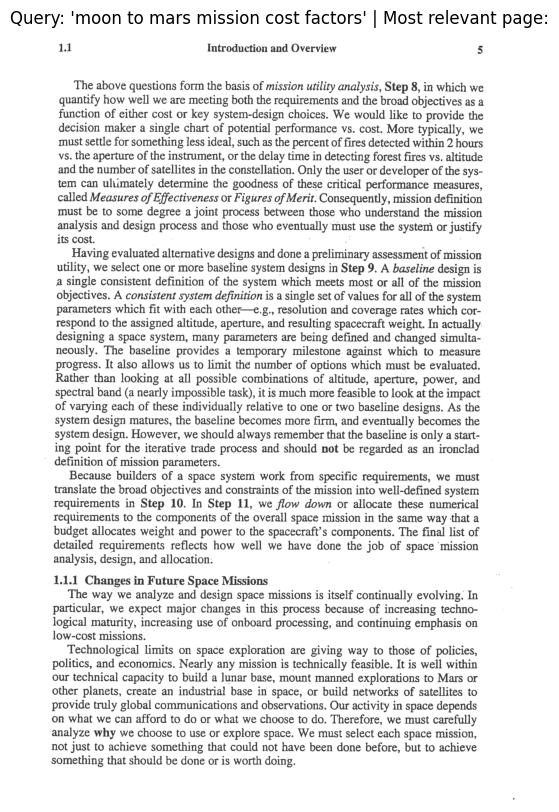

In [44]:
import fitz

# Open PDF and load target page
pdf_path = "Data sets/Space Mission Analysis and Design 3rd Edition (2005).pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 17) # number of page (our doc starts page numbers on page 17)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv, 
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

Nice!

Now we can do extra research if we'd like.

We could repeat this workflow for any kind of query we'd like on our textbook.

And it would also work for other datatypes too.

We could use semantic search on customer support documents.

Or email threads.

Or company plans.

Or our old journal entries.

Almost anything!

The workflow is the same:

`ingest documents -> split into chunks -> embed chunks -> make a query -> embed the query -> compare query embedding to chunk embeddings`

And we get relevant resources *along with* the source they came from!

That's the **retrieval** part of Retrieval Augmented Generation (RAG).

Before we get to the next two steps, let's take a small aside and discuss similarity measures.

### Similarity measures: dot product and cosine similarity 

Let's talk similarity measures between vectors.

Specifically, embedding vectors which are representations of data with magnitude and direction in high dimensional space (our embedding vectors have 768 dimensions).

Two of the most common you'll across are the dot product and cosine similarity.

They are quite similar.

The main difference is that cosine similarity has a normalization step.

| Similarity measure | Description | Code |
| ----- | ----- | ----- |
| [Dot Product](https://en.wikipedia.org/wiki/Dot_product) | - Measure of magnitude and direction between two vectors<br>- Vectors that are aligned in direction and magnitude have a higher positive value<br>- Vectors that are opposite in direction and magnitude have a higher negative value | [`torch.dot`](https://pytorch.org/docs/stable/generated/torch.dot.html), [`np.dot`](https://numpy.org/doc/stable/reference/generated/numpy.dot.html), [`sentence_transformers.util.dot_score`](https://www.sbert.net/docs/package_reference/util.html#sentence_transformers.util.dot_score) | 
| [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) | - Vectors get normalized by magnitude/[Euclidean norm](https://en.wikipedia.org/wiki/Norm_(mathematics))/L2 norm so they have unit length and are compared more so on direction<br>- Vectors that are aligned in direction have a value close to 1<br>- Vectors that are opposite in direction have a value close to -1 | [`torch.nn.functional.cosine_similarity`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cosine_similarity.html), [`1 - scipy.spatial.distance.cosine`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html) (subtract the distance from 1 for similarity measure), [`sentence_transformers.util.cos_sim`](https://www.sbert.net/docs/package_reference/util.html#sentence_transformers.util.cos_sim) |

For text similarity, you generally want to use cosine similarity as you are after the semantic measurements (direction) rather than magnitude. 

In our case, our embedding model `all-mpnet-base-v2` outputs normalized outputs (see the [Hugging Face model card](https://huggingface.co/sentence-transformers/all-mpnet-base-v2#usage-huggingface-transformers) for more on this) so dot product and cosine similarity return the same results. However, dot product is faster due to not need to perform a normalize step.

To make things bit more concrete, let's make simple dot product and cosine similarity functions and view their results on different vectors.

> **Note:** Similarity measures between vectors and embeddings can be used on any kind of embeddings, not just text embeddings. For example, you could measure image embedding similarity or audio embedding similarity. Or with text and image models like [CLIP](https://github.com/mlfoundations/open_clip), you can measure the similarity between text and image embeddings.

In [36]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Calculate cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


Notice for both dot product and cosine similarity the comparisons of `vector1` and `vector2` are the opposite of `vector1` and `vector4`.

Comparing `vector1` and `vector2` both equations return positive values (14 for dot product and 1.0 for cosine similarity). 

But comparing `vector1` and `vector4` the result is in the negative direction.

This makes sense because `vector4` is the negative version of `vector1`.

Whereas comparing `vector1` and `vector3` shows a different outcome.

For the dot product, the value is positive and larger then the comparison of two exactly the same vectors (32 vs 14).

However, for the cosine similarity, thanks to the normalization step, comparing `vector1` and `vector3` results in a postive value close to 1 but not exactly 1.

It is because of this that when comparing text embeddings, cosine similarity is generally favoured as it measures the difference in direction of a pair of vectors rather than difference in magnitude.

And it is this difference in direction that is more generally considered to capture the semantic meaning/vibe of the text.

The good news is that as mentioned before, the outputs of our embedding model `all-mpnet-base-v2` are already normalized.

So we can continue using the dot product (cosine similarity is dot product + normalization).

With similarity measures explained, let's functionize our semantic search steps from above so we can repeat them. 

### Functionizing our semantic search pipeline

Let's put all of the steps from above for semantic search into a function or two so we can repeat the workflow.

In [37]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, 
                                   convert_to_tensor=True) 

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, 
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

Excellent! Now let's test our functions out.

In [38]:
query = "symptoms of pellagra"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 1680 embeddings: 0.00002 seconds.


(tensor([0.5000, 0.3741, 0.2959, 0.2793, 0.2721], device='cuda:0'),
 tensor([ 822,  853, 1536, 1555, 1531], device='cuda:0'))

In [39]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 1680 embeddings: 0.00002 seconds.
Query: symptoms of pellagra

Results:
Score: 0.5000
Niacin deficiency is commonly known as pellagra and the symptoms include
fatigue, decreased appetite, and indigestion. These symptoms are then commonly
followed by the four D’s: diarrhea, dermatitis, dementia, and sometimes death.
Figure 9.12 Conversion of Tryptophan to Niacin Water-Soluble Vitamins | 565
Page number: 565


Score: 0.3741
car. Does it drive faster with a half-tank of gas or a full one?It does not
matter; the car drives just as fast as long as it has gas. Similarly, depletion
of B vitamins will cause problems in energy metabolism, but having more than is
required to run metabolism does not speed it up. Buyers of B-vitamin supplements
beware; B vitamins are not stored in the body and all excess will be flushed
down the toilet along with the extra money spent. B vitamins are naturally
present in numerous foods, and many other foods are enriched with them

### Semantic search/vector search extensions 

We've covered an exmaple of using embedding vector search to find relevant results based on a query.

However, you could also add to this pipeline with traditional keyword search.

Many modern search systems use keyword and vector search in tandem.

Our dataset is small and allows for an exhaustive search (comparing the query to *every* possible result) but if you start to work with large scale datasets with hundred of thousands, millions or even billions of vectors, you'll want to implement an index.

You can think of an index as sorting your embeddings before you search through them.

So it narrows down the search space.

For example, it would be inefficient to search every word in the dictionary to find the word "duck", instead you'd go straight to the letter D, perhaps even straight to the back half of the letter D, find words close to "duck" before finding it.

That's how an index can help search through many examples without comprimising too much on speed or quality (for more on this, check out [nearest neighbour search](https://en.wikipedia.org/wiki/Nearest_neighbor_search)).

One of the most popular indexing libraries is [Faiss](https://github.com/facebookresearch/faiss). 

Faiss is open-source and was originally created by Facebook to deal with internet-scale vectors and implements many algorithms such as [HNSW](https://arxiv.org/abs/1603.09320) (Hierarchical Naviganle Small Worlds).

### Getting an LLM for local generation

We're got our retrieval pipeline ready, let's now get the generation side of things happening.

To perform generation, we're going to use a Large Language Model (LLM).

LLMs are designed to generate an output given an input.

In our case, we want our LLM to generate and output of text given a input of text.

And more specifically, we want the output of text to be generated based on the context of relevant information to the query.

The input to an LLM is often referred to as a prompt.

We'll augment our prompt with a query as well as context from our textbook related to that query.

> **Which LLM should I use?**

There are many LLMs available.

Two of the main questions to ask from this is:
1. Do I want it to run locally? 
2. If yes, how much compute power can I dedicate?

If you're after the absolute best performance, you'll likely want to use an API (not running locally) such as GPT-4 or Claude 3. However, this comes with the tradeoff of sending your data away and then awaiting a response.

For our case, since we want to set up a local pipeline and run it on our own GPU, we'd answer "yes" to the first question and then the second question will depend on what hardware we have available.

To find open-source LLMs, one great resource is the [Hugging Face open LLM leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard).

The leaderboard compares many of the latest and greatest LLMs on various benchmarks.

Another great resource is [TheBloke on Hugging Face](https://huggingface.co/TheBloke), an account which provides an extensive range of quantized (models that have been made smaller) LLMs.

A rule of thumb for LLMs (and deep learning models in general) is that the higher the number of parameters, the better the model performs. 

It may be tempting to go for the largest size model (e.g. a 70B parameter model rather than a 7B parameter model) but a larger size model may not be able to run on your available hardware.

The following table gives an insight into how much GPU memory you'll need to load an LLM with different sizes and different levels of [numerical precision](https://en.wikipedia.org/wiki/Precision_(computer_science)).

They are based on the fact that 1 float32 value (e.g. `0.69420`) requires 4 bytes of memory and 1GB is approximately 1,000,000,000 (one billion) bytes.

| Model Size (Billion Parameters) | Float32 VRAM (GB) | Float16 VRAM (GB) | 8-bit VRAM (GB) | 4-bit VRAM (GB) |
|-----|-----|-----|-----|-----|
| 1B                              | ~4                | ~2                | ~1              | ~0.5            |
| 7B (e.g., [Llama 2 7B](https://huggingface.co/meta-llama/Llama-2-7b), [Gemma 7B](https://huggingface.co/google/gemma-7b-it), [Mistral 7B](https://huggingface.co/mistralai/Mistral-7B-v0.1))             | ~28               | ~14               | ~7              | ~3.5            |
| 10B                             | ~40               | ~20               | ~10             | ~5              |
| 70B (e.g, Llama 2 70B)          | ~280              | ~140              | ~70             | ~35             |
| 100B                            | ~400              | ~200              | ~100            | ~50             |
| 175B                            | ~700              | ~350              | ~175            | ~87.5           |

<br>

> **Note:** Loading a model in a lower precision (e.g. 8-bit instead of float16) generally lowers performance. Lower precision can help to reduce computing requirements, however sometimes the performance degradation in terms of model output can be substantial. Finding the right speed/performance tradeoff will often require many experiments.

### Checking local GPU memory availability

Let's find out what hardware we've got available and see what kind of model(s) we'll be able to load.

> **Note:** You can also check this with the `!nvidia-smi` command.

In [40]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 24 GB


Ok wonderful!

I'm running this notebook with a NVIDIA RTX 4090, so I've got 24GB of VRAM available.

However, this may be different on your end.

Looking at the table above, it seems we can run a ~7-10B parameter model in float16 precision pretty comfortably.

But we could also run a smaller one if we'd like.

Let's try out the recently released (at the time of writing, March 2024) LLM from Google, [Gemma](https://huggingface.co/blog/gemma).

Specifically, we'll use the `gemma-7b-it` version which stands for Gemma 7B Instruction-Tuned.

Instruction tuning is the process of tuning a raw language model to follow instructions.

These are the kind of models you'll find in most chat-based assistants such as ChatGPT, Gemini or Claude.

The following table shows different amounts of GPU memory requirements for different verions of the Gemma LLMs with varying levels of precision.

| Model             | Precision | Min-Memory (Bytes) | Min-Memory (MB) | Min-Memory (GB) | Recommended Memory (GB) | Hugging Face ID |
|-------------------|-----------|----------------|-------------|-------------| ----- | ----- |
| [Gemma 2B](https://huggingface.co/google/gemma-2b-it)          | 4-bit     | 2,106,749,952  | 2009.15     | 1.96        | ~5.0 | [`gemma-2b`](https://huggingface.co/google/gemma-2b) or [`gemma-2b-it`](https://huggingface.co/google/gemma-2b-it) for instruction tuned version | 
| Gemma 2B          | Float16   | 5,079,453,696  | 4844.14     | 4.73        | ~8.0 | Same as above |
| [Gemma 7B](https://huggingface.co/google/gemma-7b-it)          | 4-bit     | 5,515,859,968  | 5260.33     | 5.14        | ~8.0 | [`gemma-7b`](https://huggingface.co/google/gemma-7b) or [`gemma-7b-it`](https://huggingface.co/google/gemma-7b-it) for instruction tuned version |
| Gemma 7B          | Float16   | 17,142,470,656 | 16348.33    | 15.97       | ~19 | Same as above |

> **Note:** `gemma-7b-it` means "instruction tuned", as in, a base LLM (`gemma-7b`) has been fine-tuned to follow instructions, similar to [`Mistral-7B-v0.1`](https://huggingface.co/mistralai/Mistral-7B-v0.1) and [`Mistral-7B-Instruct-v0.1`](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1).
> 
> There are also further quantized and smaller variants of Gemma (and other LLMs) available in various formats such as GGUF. You can see many of these on [TheBloke account on Hugging Face](https://huggingface.co/TheBloke).
> 
> The version of LLM you choose to use will be largely based on project requirements and experimentation.

Based on the table above, let's write a simple if/else statement which recommends which Gemma variant we should look into using.

In [41]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 24 | Recommend model: Gemma 7B in 4-bit or float16 precision.
use_quantization_config set to: False
model_id set to: google/gemma-7b-it


### Loading an LLM locally

Alright! Looks like `gemma-7b-it` it is (for my local machine with an RTX 4090, change the `model_id` and `use_quantization_config` values to suit your needs)! 

There are plenty of examples of how to load the model on the `gemma-7b-it` [Hugging Face model card](https://huggingface.co/google/gemma-7b-it).

Good news is, the Hugging Face [`transformers`](https://huggingface.co/docs/transformers/) library has all the tools we need.

To load our LLM, we're going to need a few things:
1. A quantization config (optional) - This will determine whether or not we load the model in 4bit precision for lower memory usage. The we can create this with the [`transformers.BitsAndBytesConfig`](https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/quantization#transformers.BitsAndBytesConfig) class (requires installing the [`bitsandbytes` library](https://github.com/TimDettmers/bitsandbytes)).
2. A model ID - This is the reference Hugging Face model ID which will determine which tokenizer and model gets used. For example `gemma-7b-it`.
3. A tokenzier - This is what will turn our raw text into tokens ready for the model. We can create it using the [`transformers.AutoTokenzier.from_pretrained`](https://huggingface.co/docs/transformers/v4.38.2/en/model_doc/auto#transformers.AutoTokenizer) method and passing it our model ID.
4. An LLM model - Again, using our model ID we can load a specific LLM model. To do so we can use the [`transformers.AutoModelForCausalLM.from_pretrained`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForCausalLM.from_pretrained) method and passing it our model ID as well as other various parameters.

As a bonus, we'll check if [Flash Attention 2](https://huggingface.co/docs/transformers/perf_infer_gpu_one#flashattention-2) is available using `transformers.utils.is_flash_attn_2_available()`. Flash Attention 2 speeds up the attention mechanism in Transformer architecture models (which is what many modern LLMs are based on, including Gemma). So if it's available and the model is supported (not all models support Flash Attention 2), we'll use it. If it's not available, you can install it by following the instructions on the [GitHub repo](https://github.com/Dao-AILab/flash-attention). 

> **Note:** Flash Attention 2 currently works on NVIDIA GPUs with a compute capability score of 8.0+ (Ampere, Ada Lovelace, Hopper architectures). We can check our GPU compute capability score with [`torch.cuda.get_device_capability(0)`](https://pytorch.org/docs/stable/generated/torch.cuda.get_device_capability.html). 

> **Note:** To get access to the Gemma models, you will have to [agree to the terms & conditions](https://huggingface.co/google/gemma-7b-it) on the Gemma model page on Hugging Face. You will then have to authorize your local machine via the [Hugging Face CLI/Hugging Face Hub `login()` function](https://huggingface.co/docs/huggingface_hub/en/quick-start#authentication). Once you've done this, you'll be able to download the models. If you're using Google Colab, you can add a [Hugging Face token](https://huggingface.co/docs/hub/en/security-tokens) to the "Secrets" tab.
>
> Downloading an LLM locally can take a fair bit of time depending on your internet connection. Gemma 7B is about a 16GB download and Gemma 2B is about a 6GB download.

Let's do it!

In [42]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available 

# 1. Create quantization config for smaller model loading (optional)
# Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
# For models that require 4-bit quantization (use this if you have low GPU memory available)
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
# Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above, see: https://developer.nvidia.com/cuda-gpus
# Requires !pip install flash-attn, see: https://github.com/Dao-AILab/flash-attention 
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
#model_id = "google/gemma-7b-it"
model_id = model_id # (we already set this above)
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model) 
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id, 
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use full memory 
                                                 attn_implementation=attn_implementation) # which attention version to use

if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU 
    llm_model.to("cuda")

[INFO] Using attention implementation: flash_attention_2
[INFO] Using model_id: google/gemma-7b-it


You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

We've got an LLM!

Let's check it out.

In [43]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 3072, padding_idx=0)
    (layers): ModuleList(
      (0-27): 28 x GemmaDecoderLayer(
        (self_attn): GemmaFlashAttention2(
          (q_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (k_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (v_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=3072, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (up_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (down_proj): Linear(in_features=24576, out_features=3072, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): Gem

Ok, ok a bunch of layers ranging from embedding layers to attention layers (see the `GemmaFlashAttention2` layers!) to MLP and normalization layers.

The good news is that we don't have to know too much about these to use the model.

How about we get the number of parameters in our model? 

In [44]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

8537680896

Hmm, turns out that Gemma 7B is really Gemma 8.5B.

It pays to do your own investigations!

How about we get the models memory requirements?

In [45]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 17142470656,
 'model_mem_mb': 16348.33,
 'model_mem_gb': 15.97}

Nice, looks like this model takes up 15.97GB of space on the GPU.

Plus a little more for the forward pass (due to all the calculations happening between the layers).

Hence why I rounded it up to be ~19GB in the table above.

Now let's get to the fun part, generating some text!

### Generating text with our LLM

We can generate text with our LLM `model` instance by calling the [`generate()` method](https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig) (this method has plenty of options to pass into it alongside the text) on it and passing it a tokenized input.

The tokenized input comes from passing a string of text to our `tokenizer`.

It's important to note that you should use a tokenizer that has been paired with a model.

Otherwise if you try to use a different tokenizer and then pass those inputs to a model, you will likely get errors/strange results.

For some LLMs, there's a specific template you should pass to them for ideal outputs.

For example, the `gemma-7b-it` model has been trained in a dialogue fashion (instruction tuning).

In this case, our `tokenizer` has a [`apply_chat_template()` method](https://huggingface.co/docs/transformers/main/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.apply_chat_template) which can prepare our input text in the right format for the model.

Let's try it out.

> **Note:** The following demo has been modified from the Hugging Face model card for [Gemma 7B](https://huggingface.co/google/gemma-7b-it). Many similar demos of usage are available on the model cards of similar models.

In [46]:
input_text = "What are the macronutrients, and what roles do they play in the human body?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the macronutrients, and what roles do they play in the human body?

Prompt (formatted):
<bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model



Notice the scaffolding around our input text, this is the kind of turn-by-turn instruction tuning our model has gone through.

Our next step is to tokenize this formatted text and pass it to our model's `generate()` method.

We'll make sure our tokenized text is on the same device as our model (GPU) using `to("cuda")`.

Let's generate some text! 

We'll time it for fun with the `%%time` magic.

In [47]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig 
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
         184592, 235269,    578,   1212,  16065,    749,    984,   1554,    575,
            573,   3515,   2971, 235336,    107,    108,    106,   2516,    108]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
        184592, 235269,    578,   1212,  16065,    749,    984,   1554,    575,
           573,   3515,   2971, 235336,    107,    108,    106,   2516,    108,
         21404, 235269,   1517,    708,    573, 186809, 184592,    578,   1024,
         16065,    575,    573,   3515,   2971, 235292,    109,    688,  12298,
          1695, 184592,  66058,    109,    688, 235274, 235265, 110165,  56227,
         66058,    109, 235290,   5231,  11071,  6

Woohoo! We just generated some text on our local GPU!

Well not just yet...

Our LLM accepts tokens in and sends tokens back out.

We can conver the output tokens to text using [`tokenizer.decode()`](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.decode).

In [48]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model
Sure, here are the macronutrients and their roles in the human body:

**Macronutrients:**

**1. Carbohydrates:**

- **Role:**
  - Provide energy for the body.
  - Help regulate blood sugar levels.
  - Provide fiber for digestion and gut health.

**2. Proteins:**

- **Role:**
  - Build and repair tissues.
  - Create enzymes and other chemicals.
  - Help regulate blood sugar levels.

**3. Fats:**

- **Role:**
  - Provide energy storage.
  - Help absorb vitamins and minerals.
  - Help regulate blood sugar levels.

**Other Functions:**

- Macronutrients play a role in regulating the body's metabolism, which is the process of breaking down food into energy.
- They also help to build and repair tissues, and to produce energy for the body.
- Macronutrients are essential for overall health and well-being.<eos>



Woah! That looks like a pretty good answer.

But notice how the output contains the prompt text as well?

How about we do a little formatting to replace the prompt in the output text?

> **Note:** `"<bos>"` and `"<eos>"` are special tokens to denote "beginning of sentence" and "end of sentence" respectively.

In [49]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: What are the macronutrients, and what roles do they play in the human body?

Output text:
Sure, here are the macronutrients and their roles in the human body:

**Macronutrients:**

**1. Carbohydrates:**

- **Role:**
  - Provide energy for the body.
  - Help regulate blood sugar levels.
  - Provide fiber for digestion and gut health.

**2. Proteins:**

- **Role:**
  - Build and repair tissues.
  - Create enzymes and other chemicals.
  - Help regulate blood sugar levels.

**3. Fats:**

- **Role:**
  - Provide energy storage.
  - Help absorb vitamins and minerals.
  - Help regulate blood sugar levels.

**Other Functions:**

- Macronutrients play a role in regulating the body's metabolism, which is the process of breaking down food into energy.
- They also help to build and repair tissues, and to produce energy for the body.
- Macronutrients are essential for overall health and well-being.


How cool is that!

We just officially generated text from an LLM running locally.

So we've covered the R (retrieval) and G (generation) of RAG.

How about we check out the last step?

Augmentation.

First, let's put together a list of queries we can try out with our pipeline.

In [50]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions

And now let's check if our `retrieve_relevant_resources()` function works with our list of queries.

In [51]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: How do vitamins and minerals differ in their roles and importance for health?
[INFO] Time taken to get scores on 1680 embeddings: 0.00004 seconds.


(tensor([0.6322, 0.6220, 0.6187, 0.6178, 0.6128], device='cuda:0'),
 tensor([ 51,  47, 874,  41, 927], device='cuda:0'))

Beautiful!

Let's augment!

### Augmenting our prompt with context items

What we'd like to do with augmentation is take the results from our search for relevant resources and put them into the prompt that we pass to our LLM.

In essence, we start with a base prompt and update it with context text.

Let's write a function called `prompt_formatter` that takes in a query and our list of context items (in our case it'll be select indices from our list of dictionaries inside `pages_and_chunks`) and then formats the query with text from the context items.

We'll apply the dialogue and chat template to our prompt before returning it as well.

> **Note:** The process of augmenting or changing a prompt to an LLM is known as prompt engineering. And the best way to do it is an active area of research. For a comprehensive guide on different prompt engineering techniques, I'd recommend the Prompt Engineering Guide ([promptingguide.ai](https://www.promptingguide.ai/)), [Brex's Prompt Engineering Guide](https://github.com/brexhq/prompt-engineering) and the paper [Prompt Design and Engineering: Introduction and Advanced Models](https://arxiv.org/abs/2401.14423).

In [52]:
def prompt_formatter(query: str, 
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Update base prompt with context items and query   
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

Looking good! Let's try our function out.

In [53]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
    
# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: How often should infants be breastfed?
[INFO] Time taken to get scores on 1680 embeddings: 0.00003 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and

What a good looking prompt!

We can tokenize this and pass it straight to our LLM. 

In [54]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt 

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: How often should infants be breastfed?
RAG answer:
<bos>**Relevant passages:**

"A newborn infant (birth to 28 days) requires feedings eight to twelve times a day or more. Between 1 and 3 months of age, the breastfed infant becomes more efficient, and the number of feedings per day often become fewer even though the amount of milk consumed stays the same. After about six months, infants can gradually begin to consume solid foods to help meet nutrient needs."

"The US Department of Agriculture’s Women, Infants, and Children program provides information on breastfeeding and both professional and peer support for women and their babies from low-income families."

**Answer:**

Infants should be breastfed eight to twelve times a day or more when they are newborns and as often as they need when they are between 1 and 3 months old. After about six months, infants can gradually begin to consume solid foods to help meet nutrient needs.<eos>
CPU times: total: 266 ms
Wall time: 6.11 s


Yesssssss!!!

Our RAG pipeline is complete!

We just Retrieved, Augmented and Generated!

And all on our own local GPU!

How about we functionize the generation step to make it easier to use?

We can put a little formatting on the text being returned to make it look nice too.

And we'll make an option to return the context items if needed as well.

In [55]:
def ask(query, 
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True, 
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """
    
    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)
    
    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU 
        
    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)
    
    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)
    
    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text
    
    return output_text, context_items

What a good looking function!

The workflow could probably be a little refined but this should work!

Let's try it out.

In [56]:
query = random.choice(query_list)
print(f"Query: {query}")

# Answer query with context and return context 
answer, context_items = ask(query=query, 
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: What are the macronutrients, and what roles do they play in the human body?
[INFO] Time taken to get scores on 1680 embeddings: 0.00003 seconds.
Answer:

Sure, here is the answer to the query:  Macronutrients are the nutrients that
are needed in large amounts by the human body. There are three classes of
macronutrients: carbohydrates, lipids, and proteins. These macronutrients can be
metabolically processed into cellular energy.  Carbohydrates are molecules
composed of carbon, hydrogen, and oxygen. Proteins are macromolecules composed
of chains of subunits called amino acids. Lipids are molecules that are composed
of fatty acids and glycerol. Water is also a macronutrient in the sense that you
require a large amount of it, but unlike the other macronutrients, it does not
yield calories.
Context items:


[{'page_number': 5,
  'sentence_chunk': 'Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are molecules composed of c

Local RAG workflow complete!

We've now officially got a way to Retrieve, Augment and Generate answers based on a source.

For now we can verify our answers manually by reading them and reading through the textbook.

But if you want to put this into a production system, it'd be a good idea to have some kind of evaluation on how well our pipeline works.

For example, you could use another LLM to rate the answers returned by our LLM and then use those ratings as a proxy evaluation.

However, I'll leave this and a few more interesting ideas as extensions.

## Extensions

* May want to improve text extraction with something like Marker - https://github.com/VikParuchuri/marker
* Guide to more advanced PDF extraction - https://towardsdatascience.com/extracting-text-from-pdf-files-with-python-a-comprehensive-guide-9fc4003d517 
* See the following prompt engineering resources for more prompting techniques - promptinguide.ai, Brex's Prompt Engineering Guide 
* What happens when a query comes through that there isn't any context in the textbook on?
* Try another embedding model (e.g. Mixed Bread AI large, `mixedbread-ai/mxbai-embed-large-v1`, see: https://huggingface.co/mixedbread-ai/mxbai-embed-large-v1)
* Try another LLM... (e.g. Mistral-Instruct)
* Try different prompts (e.g. see prompting techniques online)
* Our example only focuses on text from a PDF, however, we could extend it to include figures and images 
* Evaluate the answers -> could use another LLM to rate our answers (e.g. use GPT-4 to make)
* Vector database/index for larger setup (e.g. 100,000+ chunks)
* Libraries/frameworks such as LangChain / LlamaIndex can help do many of the steps for you - so it's worth looking into those next, wanted to recreate a workflow with lower-level tools to show the principles
* Optimizations for speed
    * See Hugging Face docs for recommended speed ups on GPU - https://huggingface.co/docs/transformers/perf_infer_gpu_one 
    * Optimum NVIDIA - https://huggingface.co/blog/optimum-nvidia, GitHub: https://github.com/huggingface/optimum-nvidia 
    * See NVIDIA TensorRT-LLM - https://github.com/NVIDIA/TensorRT-LLM 
    * See GPT-Fast for PyTorch-based optimizations - https://github.com/pytorch-labs/gpt-fast 
    * Flash attention 2 (requires Ampere GPUs or newer) - https://github.com/Dao-AILab/flash-attention
* Stream text output so it looks prettier (e.g. each token appears as it gets output from the model)
* Turn the workflow into an app, see Gradio type chatbots for this - https://www.gradio.app/guides/creating-a-chatbot-fast, see local example: https://www.gradio.app/guides/creating-a-chatbot-fast#example-using-a-local-open-source-llm-with-hugging-face 